In [1]:
# !pip install 'zarr<3'
# !pip install timm
# !pip install openslide-python tiffslide
# !pip install pyarrow
# !pip install shapely
# !pip install scikit-image
# !pip install opencv-python

# # Install CuPy (will auto-detect CUDA version)
# #Install CuPy pre-built binary for CUDA 12.x
# !pip install cupy-cuda12x

In [2]:
import torch
print(f"PyTorch CUDA version: {torch.version.cuda}")

# Then install matching CuPy:
# CUDA 11.x → !pip install cupy-cuda11x
# CUDA 12.x → !pip install cupy-cuda12x

PyTorch CUDA version: 12.1


In [3]:

# Verify CuPy installation
import cupy as cp
print(f'✅ CuPy installed: {cp.cuda.runtime.getDeviceCount()} GPU(s) available')

✅ CuPy installed: 2 GPU(s) available


In [4]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")


✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


## Flex 

Using device: cuda
✓ VitaminPFlex initialized with large backbone
  Architecture: Shared Encoder → 4 Separate Decoders
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]
Grid: 11x11 tiles

Running inference...


100%|██████████| 121/121 [00:21<00:00,  5.61it/s]


Total raw cells: 13071

Phase 1: Running Topology 'Hard Drop'...
Hard Drop: Removed 3106 border artifacts.
Survivors: 9965

Phase 2: Running Iterative Clustering...
  Iteration 1/20... Found 2689 overlap groups. Remaining: 3458
  Iteration 2/20... Found 593 overlap groups. Remaining: 2759
  Iteration 3/20... Found 100 overlap groups. Remaining: 2658
  Iteration 4/20... Found 17 overlap groups. Remaining: 2641
  Iteration 5/20... Found 2 overlap groups. Remaining: 2639
  Iteration 6/20... Found 0 overlap groups. Remaining: 2639
  Converged! No overlaps remaining.

Generating results...
Saved final_result_hard_drop.png
Saved segmentation_results.geojson


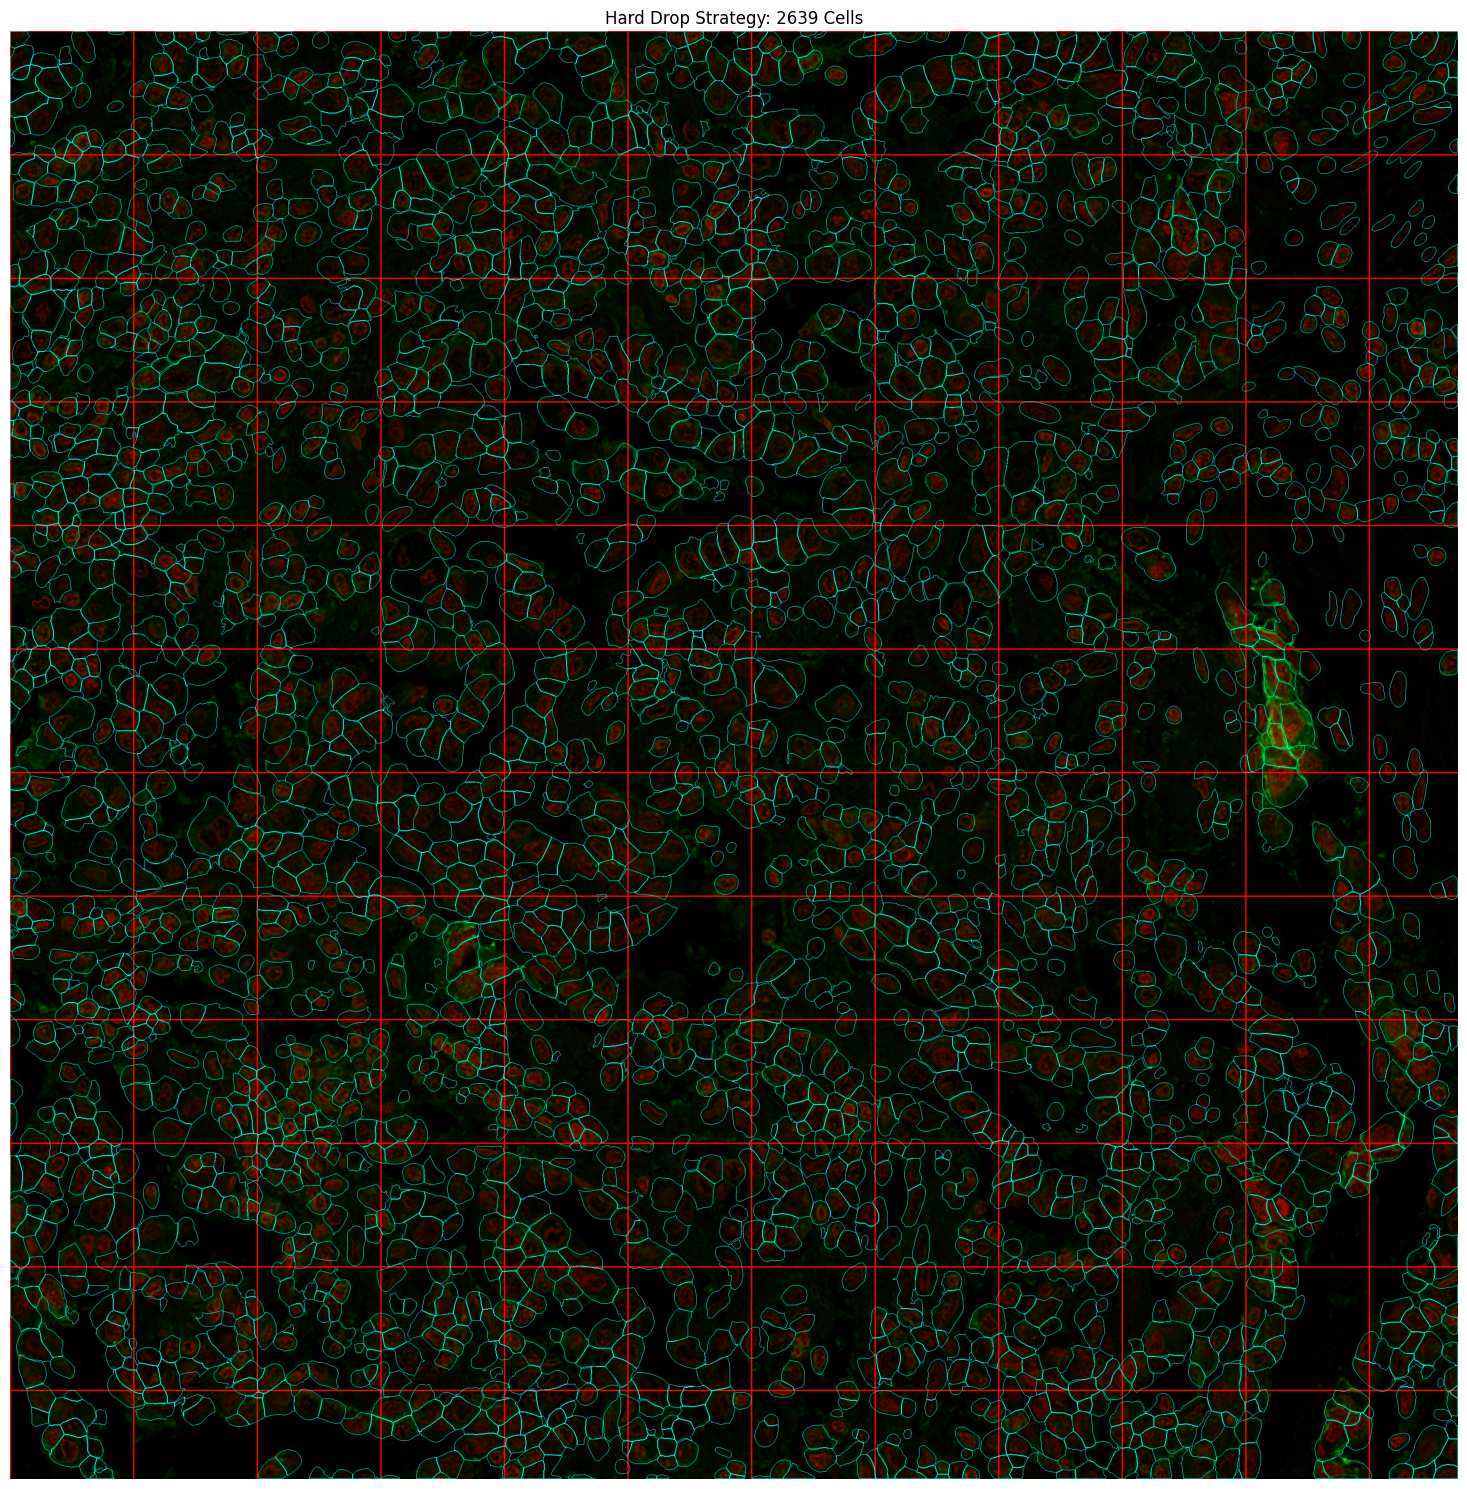

In [19]:
# ============================================================================
# WHOLE-SLIDE INFERENCE WITH "HARD DROP" CLEANING (PACKAGE STRATEGY)
# ============================================================================

import torch
import numpy as np
import cv2
import tifffile
import json
from shapely.geometry import Polygon
from shapely import strtree
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque

# Your model setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from vitaminp import VitaminPFlex, SimplePreprocessing, prepare_mif_input
from vitaminp.postprocessing.hv_postprocess import process_model_outputs

print(f"Using device: {device}")

# ============================================================================
# 1. SETUP & INFERENCE
# ============================================================================
# Load Model
model = VitaminPFlex(model_size='large').to(device)
model.load_state_dict(torch.load("checkpoints/vitamin_p_flex_large_fold21_best.pth", map_location=device))
model.eval()
preprocessor = SimplePreprocessing()

# Load Image
input_path = 'test_images/combined_2channel_crop_3000x3000.ome.tif'
image = tifffile.imread(input_path)
if image.ndim == 3 and image.shape[0] == 2: image = np.transpose(image, (1, 2, 0))
if image.max() > 1.0: image = image.astype(np.float32) / image.max()
h, w = image.shape[:2]

# Grid Setup
tile_size = 512
overlap = 256
stride = tile_size - overlap
n_tiles_h = int(np.ceil((h - overlap) / stride))
n_tiles_w = int(np.ceil((w - overlap) / stride))

print(f"Grid: {n_tiles_h}x{n_tiles_w} tiles")

tiles = []
grid_indices = [] # Track (row, col) for every tile

for i in range(n_tiles_h):
    for j in range(n_tiles_w):
        y1 = i * stride
        x1 = j * stride
        y2 = min(y1 + tile_size, h)
        x2 = min(x1 + tile_size, w)
        if y2 - y1 < tile_size: y1 = max(0, y2 - tile_size)
        if x2 - x1 < tile_size: x1 = max(0, x2 - tile_size)
        
        tiles.append(image[y1:y2, x1:x2])
        grid_indices.append((i, j, y1, x1)) # Store grid index + global pos

# Inference Loop
print("\nRunning inference...")
all_cells = []

for idx, (tile, grid_info) in enumerate(tqdm(zip(tiles, grid_indices), total=len(tiles))):
    row_idx, col_idx, y1, x1 = grid_info
    
    # Inference
    tile_tensor = torch.from_numpy(tile).permute(2, 0, 1).unsqueeze(0).to(device)
    tile_tensor = prepare_mif_input(tile_tensor)
    tile_tensor = preprocessor.percentile_normalize(tile_tensor)
    with torch.no_grad():
        outputs = model(tile_tensor)
    seg = outputs['mif_cell_seg'][0, 0].cpu().numpy()
    hv = outputs['mif_cell_hv'][0].cpu().numpy()
    inst_map, inst_info, _ = process_model_outputs(
        seg_pred=seg, h_map=hv[0], v_map=hv[1],
        magnification=40, mpp=0.263, binary_threshold=0.3,
        min_area_um=10.0, use_gpu=True
    )
    
    # Process Instances with DIRECTIONAL flags
    for inst_id, cell_data in inst_info.items():
        contour_local = cell_data['contour']
        
        lx_min = np.min(contour_local[:, 0])
        lx_max = np.max(contour_local[:, 0])
        ly_min = np.min(contour_local[:, 1])
        ly_max = np.max(contour_local[:, 1])

        # CHECK 4 BOUNDARIES SEPARATELY (The Package Strategy)
        # Margin of 2px for safety
        touches_top = (ly_min <= 2)
        touches_bottom = (ly_max >= tile_size - 3)
        touches_left = (lx_min <= 2)
        touches_right = (lx_max >= tile_size - 3)

        contour_global = contour_local + np.array([x1, y1])

        all_cells.append({
            'contour': contour_global,
            'area': cv2.contourArea(contour_local.astype(np.float32)),
            'tile_row': row_idx,
            'tile_col': col_idx,
            'touches_top': touches_top,
            'touches_bottom': touches_bottom,
            'touches_left': touches_left,
            'touches_right': touches_right
        })

print(f"Total raw cells: {len(all_cells)}")

# ============================================================================
# 2. PHASE 1: THE "HARD DROP" (Topology Cleaning)
# ============================================================================
# Logic: If a cell touches the Right Border, AND there is a tile to the Right,
# DELETE IT. Assume the Right Tile has captured it better.
print("\nPhase 1: Running Topology 'Hard Drop'...")

surviving_cells = []
dropped_count = 0

for cell in all_cells:
    r, c = cell['tile_row'], cell['tile_col']
    
    drop = False
    
    # Check Top
    if cell['touches_top']:
        # If there is a neighbor above (row > 0), drop this cell
        if r > 0: drop = True
            
    # Check Bottom
    if cell['touches_bottom']:
        # If there is a neighbor below, drop this cell
        if r < n_tiles_h - 1: drop = True
            
    # Check Left
    if cell['touches_left']:
        # If neighbor to left, drop
        if c > 0: drop = True
            
    # Check Right
    if cell['touches_right']:
        # If neighbor to right, drop
        if c < n_tiles_w - 1: drop = True
            
    if drop:
        dropped_count += 1
    else:
        # Prepare for Phase 2: Create Polygon object
        try:
            poly = Polygon(cell['contour'])
            if not poly.is_valid: poly = poly.buffer(0)
            if not poly.is_empty:
                cell['poly'] = poly
                surviving_cells.append(cell)
        except:
            continue

print(f"Hard Drop: Removed {dropped_count} border artifacts.")
print(f"Survivors: {len(surviving_cells)}")


# ============================================================================
# 3. PHASE 2: ITERATIVE OVERLAP REMOVAL (The Package Loop)
# ============================================================================
# Logic: Loop until no overlaps exist. If overlaps, keep LARGEST area.
print("\nPhase 2: Running Iterative Clustering...")

# Give every cell a unique ID for tracking
for i, cell in enumerate(surviving_cells):
    cell['uid'] = i

current_cells = surviving_cells
max_iterations = 20
overlap_threshold = 0.01  # 1% overlap (Very strict, same as package)

for iteration in range(max_iterations):
    print(f"  Iteration {iteration+1}/{max_iterations}...", end="")
    
    # Build Tree
    geometries = [c['poly'] for c in current_cells]
    if not geometries: break
    tree = strtree.STRtree(geometries)
    
    to_keep_uids = []
    processed_uids = set()
    overlaps_found = 0
    
    # Iterate all cells
    for i, cell in enumerate(current_cells):
        if cell['uid'] in processed_uids:
            continue
            
        # Find overlaps
        candidates = tree.query(cell['poly'])
        
        # Identify the cluster
        cluster = []
        for cand_idx in candidates:
            candidate = current_cells[cand_idx]
            if candidate['uid'] in processed_uids: continue
            
            # IoU / Coverage Check (matches package logic)
            # They check: (Inter / Area A) > 1% OR (Inter / Area B) > 1%
            inter_area = cell['poly'].intersection(candidate['poly']).area
            if inter_area == 0: continue
            
            ratio_a = inter_area / cell['area']
            ratio_b = inter_area / candidate['area']
            
            if ratio_a > overlap_threshold or ratio_b > overlap_threshold or cell['uid'] == candidate['uid']:
                cluster.append(candidate)
        
        if not cluster:
            # No overlaps (should at least find self, but safety check)
            to_keep_uids.append(cell['uid'])
            processed_uids.add(cell['uid'])
            continue
            
        # Resolve Cluster: Keep LARGEST Area
        if len(cluster) > 1:
            overlaps_found += 1
            # Sort by area descending
            cluster.sort(key=lambda x: x['area'], reverse=True)
            winner = cluster[0]
            to_keep_uids.append(winner['uid'])
            
            # Mark all as processed
            for c in cluster:
                processed_uids.add(c['uid'])
        else:
            # Just self
            to_keep_uids.append(cluster[0]['uid'])
            processed_uids.add(cluster[0]['uid'])
    
    # Re-build list for next iteration
    next_cells = [c for c in current_cells if c['uid'] in to_keep_uids]
    current_cells = next_cells
    
    print(f" Found {overlaps_found} overlap groups. Remaining: {len(current_cells)}")
    
    if overlaps_found == 0:
        print("  Converged! No overlaps remaining.")
        break

final_cells = current_cells

# ============================================================================
# 4. VISUALIZATION & EXPORT
# ============================================================================
print("\nGenerating results...")

# Create Visualization
vis = np.zeros((h, w, 3), dtype=np.uint8)
vis[:, :, 0] = (image[:, :, 0] * 255).astype(np.uint8)
vis[:, :, 1] = (image[:, :, 1] * 255).astype(np.uint8)

# Draw Grid
for i in range(n_tiles_h + 1):
    y = i * stride
    if y <= h: cv2.line(vis, (0, y), (w, y), (255, 0, 0), 2)
for j in range(n_tiles_w + 1):
    x = j * stride
    if x <= w: cv2.line(vis, (x, 0), (x, h), (255, 0, 0), 2)

# Draw Final Cells
for cell in final_cells:
    cnt = cell['contour'].astype(np.int32)
    cv2.drawContours(vis, [cnt], -1, (0, 255, 255), 1)

plt.figure(figsize=(15, 15))
plt.imshow(vis)
plt.axis('off')
plt.title(f"Hard Drop Strategy: {len(final_cells)} Cells")
plt.tight_layout()
plt.savefig("final_result_hard_drop.png", dpi=150)
print("Saved final_result_hard_drop.png")

# GeoJSON Export
features = []
for i, cell in enumerate(final_cells):
    contour_list = cell['contour'].tolist()
    if not np.array_equal(contour_list[0], contour_list[-1]):
        contour_list.append(contour_list[0])
    
    features.append({
        "type": "Feature",
        "geometry": {"type": "Polygon", "coordinates": [contour_list]},
        "properties": {"id": i, "area": float(cell['area'])}
    })

with open("segmentation_results.geojson", 'w') as f:
    json.dump({"type": "FeatureCollection", "features": features}, f)
print("Saved segmentation_results.geojson")

## WSI Xenium

In [ ]:
# ============================================================================
# WHOLE-SLIDE INFERENCE WITH "HARD DROP" CLEANING - XENIUM FULL WSI VERSION
# ============================================================================

import torch
import numpy as np
import cv2
import tifffile
import json
import os
from shapely.geometry import Polygon
from shapely import strtree
import matplotlib.pyplot as plt
from tqdm import tqdm

# ============================================================================
# 0. LOAD XENIUM DATA
# ============================================================================
print("="*60)
print("READING ORIGINAL XENIUM CHANNELS")
print("="*60)

# Set paths to original Xenium data
data_dir = "/rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/Lung_Anthracosis/output-XETG00522__0057986__Region_1__20251203__234028"
morphology_focus_dir = f"{data_dir}/morphology_focus"

# Read DAPI channel
dapi_path = f"{morphology_focus_dir}/ch0000_dapi.ome.tif"
print(f"\nReading DAPI: {dapi_path}")
with tifffile.TiffFile(dapi_path) as tif:
    dapi = tif.pages[0].asarray()
    print(f"  ✅ DAPI loaded: {dapi.shape}, dtype={dapi.dtype}")

# Read CD45/E-cadherin channel
cd45_path = f"{morphology_focus_dir}/ch0001_atp1a1_cd45_e-cadherin.ome.tif"
print(f"Reading CD45/E-cadherin: {cd45_path}")
with tifffile.TiffFile(cd45_path) as tif:
    cd45_ecadherin = tif.pages[0].asarray()
    print(f"  ✅ CD45/E-cadherin loaded: {cd45_ecadherin.shape}, dtype={cd45_ecadherin.dtype}")

# Stack into 2-channel image (channels, height, width)
combined = np.stack([dapi, cd45_ecadherin], axis=0)
print(f"\n✅ Combined shape: {combined.shape} (channels, height, width)")

# Convert to (height, width, channels) format for processing
image = np.transpose(combined, (1, 2, 0))
print(f"✅ Transposed shape: {image.shape} (height, width, channels)")

# Normalize to [0, 1] if needed
if image.max() > 1.0:
    image = image.astype(np.float32) / image.max()
    print(f"✅ Normalized to [0, 1] range")

h, w = image.shape[:2]
print(f"\n{'='*60}")
print(f"FULL WSI SIZE: {w} x {h} pixels")
print(f"Size in microns: {w*0.2125:.1f} x {h*0.2125:.1f} μm")
print(f"{'='*60}")

# ============================================================================
# 1. SETUP & INFERENCE
# ============================================================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from vitaminp import VitaminPFlex, SimplePreprocessing, prepare_mif_input
from vitaminp.postprocessing.hv_postprocess import process_model_outputs

print(f"\nUsing device: {device}")

# Load Model
print("\nLoading model...")
model = VitaminPFlex(model_size='large').to(device)
model.load_state_dict(torch.load("checkpoints/vitamin_p_flex_large_fold21_best.pth", map_location=device))
model.eval()
preprocessor = SimplePreprocessing()
print("✅ Model loaded")

# Grid Setup
tile_size = 512
overlap = 64
stride = tile_size - overlap
n_tiles_h = int(np.ceil((h - overlap) / stride))
n_tiles_w = int(np.ceil((w - overlap) / stride))

print(f"\n{'='*60}")
print(f"TILING CONFIGURATION")
print(f"{'='*60}")
print(f"Tile size: {tile_size}x{tile_size}")
print(f"Overlap: {overlap} pixels")
print(f"Stride: {stride} pixels")
print(f"Grid: {n_tiles_h}x{n_tiles_w} = {n_tiles_h * n_tiles_w} tiles")
print(f"{'='*60}")

# Generate tiles
tiles = []
grid_indices = []  # Track (row, col) for every tile

for i in range(n_tiles_h):
    for j in range(n_tiles_w):
        y1 = i * stride
        x1 = j * stride
        y2 = min(y1 + tile_size, h)
        x2 = min(x1 + tile_size, w)
        if y2 - y1 < tile_size: y1 = max(0, y2 - tile_size)
        if x2 - x1 < tile_size: x1 = max(0, x2 - tile_size)
        
        tiles.append(image[y1:y2, x1:x2])
        grid_indices.append((i, j, y1, x1))  # Store grid index + global pos

# ============================================================================
# INFERENCE LOOP
# ============================================================================
print(f"\n{'='*60}")
print("RUNNING INFERENCE ON ALL TILES")
print(f"{'='*60}")

all_cells = []

for idx, (tile, grid_info) in enumerate(tqdm(zip(tiles, grid_indices), total=len(tiles), desc="Processing tiles")):
    row_idx, col_idx, y1, x1 = grid_info
    
    # Inference
    tile_tensor = torch.from_numpy(tile).permute(2, 0, 1).unsqueeze(0).to(device)
    tile_tensor = prepare_mif_input(tile_tensor)
    tile_tensor = preprocessor.percentile_normalize(tile_tensor)
    
    with torch.no_grad():
        outputs = model(tile_tensor)
    
    seg = outputs['mif_cell_seg'][0, 0].cpu().numpy()
    hv = outputs['mif_cell_hv'][0].cpu().numpy()
    
    inst_map, inst_info, _ = process_model_outputs(
        seg_pred=seg, h_map=hv[0], v_map=hv[1],
        magnification=40, mpp=0.2125,  # Xenium pixel size
        binary_threshold=0.3,
        min_area_um=10.0,
        use_gpu=True
    )
    
    # Process Instances with DIRECTIONAL flags
    for inst_id, cell_data in inst_info.items():
        contour_local = cell_data['contour']
        
        lx_min = np.min(contour_local[:, 0])
        lx_max = np.max(contour_local[:, 0])
        ly_min = np.min(contour_local[:, 1])
        ly_max = np.max(contour_local[:, 1])

        # CHECK 4 BOUNDARIES SEPARATELY (The Package Strategy)
        # Margin of 2px for safety
        touches_top = (ly_min <= 2)
        touches_bottom = (ly_max >= tile_size - 3)
        touches_left = (lx_min <= 2)
        touches_right = (lx_max >= tile_size - 3)

        contour_global = contour_local + np.array([x1, y1])

        all_cells.append({
            'contour': contour_global,
            'area': cv2.contourArea(contour_local.astype(np.float32)),
            'tile_row': row_idx,
            'tile_col': col_idx,
            'touches_top': touches_top,
            'touches_bottom': touches_bottom,
            'touches_left': touches_left,
            'touches_right': touches_right
        })

print(f"\n✅ Total raw cells detected: {len(all_cells)}")

# ============================================================================
# 2. PHASE 1: THE "HARD DROP" (Topology Cleaning)
# ============================================================================
print(f"\n{'='*60}")
print("PHASE 1: TOPOLOGY 'HARD DROP' CLEANING")
print(f"{'='*60}")

surviving_cells = []
dropped_count = 0

for cell in all_cells:
    r, c = cell['tile_row'], cell['tile_col']
    
    drop = False
    
    # Check Top
    if cell['touches_top']:
        if r > 0: drop = True
            
    # Check Bottom
    if cell['touches_bottom']:
        if r < n_tiles_h - 1: drop = True
            
    # Check Left
    if cell['touches_left']:
        if c > 0: drop = True
            
    # Check Right
    if cell['touches_right']:
        if c < n_tiles_w - 1: drop = True
            
    if drop:
        dropped_count += 1
    else:
        # Prepare for Phase 2: Create Polygon object
        try:
            poly = Polygon(cell['contour'])
            if not poly.is_valid: poly = poly.buffer(0)
            if not poly.is_empty:
                cell['poly'] = poly
                surviving_cells.append(cell)
        except:
            continue

print(f"✅ Hard Drop: Removed {dropped_count} border artifacts")
print(f"✅ Survivors: {len(surviving_cells)}")

# ============================================================================
# 3. PHASE 2: ITERATIVE OVERLAP REMOVAL (The Package Loop)
# ============================================================================
print(f"\n{'='*60}")
print("PHASE 2: ITERATIVE OVERLAP CLUSTERING")
print(f"{'='*60}")

# Give every cell a unique ID for tracking
for i, cell in enumerate(surviving_cells):
    cell['uid'] = i

current_cells = surviving_cells
max_iterations = 20
overlap_threshold = 0.01  # 1% overlap

for iteration in range(max_iterations):
    print(f"  Iteration {iteration+1}/{max_iterations}...", end="")
    
    # Build Tree
    geometries = [c['poly'] for c in current_cells]
    if not geometries: break
    tree = strtree.STRtree(geometries)
    
    to_keep_uids = []
    processed_uids = set()
    overlaps_found = 0
    
    # Iterate all cells
    for i, cell in enumerate(current_cells):
        if cell['uid'] in processed_uids:
            continue
            
        # Find overlaps
        candidates = tree.query(cell['poly'])
        
        # Identify the cluster
        cluster = []
        for cand_idx in candidates:
            candidate = current_cells[cand_idx]
            if candidate['uid'] in processed_uids: continue
            
            # IoU / Coverage Check
            inter_area = cell['poly'].intersection(candidate['poly']).area
            if inter_area == 0: continue
            
            ratio_a = inter_area / cell['area']
            ratio_b = inter_area / candidate['area']
            
            if ratio_a > overlap_threshold or ratio_b > overlap_threshold or cell['uid'] == candidate['uid']:
                cluster.append(candidate)
        
        if not cluster:
            to_keep_uids.append(cell['uid'])
            processed_uids.add(cell['uid'])
            continue
            
        # Resolve Cluster: Keep LARGEST Area
        if len(cluster) > 1:
            overlaps_found += 1
            cluster.sort(key=lambda x: x['area'], reverse=True)
            winner = cluster[0]
            to_keep_uids.append(winner['uid'])
            
            for c in cluster:
                processed_uids.add(c['uid'])
        else:
            to_keep_uids.append(cluster[0]['uid'])
            processed_uids.add(cluster[0]['uid'])
    
    # Re-build list for next iteration
    next_cells = [c for c in current_cells if c['uid'] in to_keep_uids]
    current_cells = next_cells
    
    print(f" Found {overlaps_found} overlap groups. Remaining: {len(current_cells)}")
    
    if overlaps_found == 0:
        print("  ✅ Converged! No overlaps remaining.")
        break

final_cells = current_cells

# ============================================================================
# 4. CALCULATE STATISTICS
# ============================================================================
print(f"\n{'='*60}")
print("FINAL RESULTS")
print(f"{'='*60}")
print(f"✅ Total cells detected: {len(final_cells)}")

# Calculate area statistics in μm²
pixel_to_um2 = (0.2125 ** 2)  # Xenium pixel size
areas_um = [cell['area'] * pixel_to_um2 for cell in final_cells]

if areas_um:
    print(f"\nCell area statistics:")
    print(f"  Mean: {np.mean(areas_um):.2f} μm²")
    print(f"  Median: {np.median(areas_um):.2f} μm²")
    print(f"  Min: {np.min(areas_um):.2f} μm²")
    print(f"  Max: {np.max(areas_um):.2f} μm²")

# ============================================================================
# 5. SAVE RESULTS
# ============================================================================
print(f"\n{'='*60}")
print("SAVING RESULTS")
print(f"{'='*60}")

# Create output directory
output_dir = "results_xenium_fullwsi"
os.makedirs(output_dir, exist_ok=True)

# Save GeoJSON
print(f"\nSaving GeoJSON...")
features = []
for i, cell in enumerate(final_cells):
    contour_list = cell['contour'].tolist()
    if not np.array_equal(contour_list[0], contour_list[-1]):
        contour_list.append(contour_list[0])
    
    area_um2 = cell['area'] * pixel_to_um2
    
    features.append({
        "type": "Feature",
        "geometry": {"type": "Polygon", "coordinates": [contour_list]},
        "properties": {
            "id": i,
            "area_pixels": float(cell['area']),
            "area_um2": float(area_um2)
        }
    })

geojson_path = f"{output_dir}/segmentation_results.geojson"
with open(geojson_path, 'w') as f:
    json.dump({"type": "FeatureCollection", "features": features}, f)
print(f"✅ Saved: {geojson_path}")

# Save visualization (downsampled for large images)
print(f"\nGenerating visualization...")
downsample_factor = max(1, max(h, w) // 4000)  # Limit to ~4000 pixels max dimension

if downsample_factor > 1:
    vis_h = h // downsample_factor
    vis_w = w // downsample_factor
    vis_image = cv2.resize(image, (vis_w, vis_h))
    print(f"  Downsampling by {downsample_factor}x for visualization: {vis_w}x{vis_h}")
else:
    vis_image = image
    vis_h, vis_w = h, w

# Create RGB visualization
vis = np.zeros((vis_h, vis_w, 3), dtype=np.uint8)
vis[:, :, 0] = (vis_image[:, :, 0] * 255).astype(np.uint8)  # DAPI
vis[:, :, 1] = (vis_image[:, :, 1] * 255).astype(np.uint8)  # CD45/E-cadherin

# Draw grid (downsampled)
for i in range(n_tiles_h + 1):
    y = (i * stride) // downsample_factor
    if y <= vis_h: cv2.line(vis, (0, y), (vis_w, y), (255, 0, 0), 1)
for j in range(n_tiles_w + 1):
    x = (j * stride) // downsample_factor
    if x <= vis_w: cv2.line(vis, (x, 0), (x, vis_h), (255, 0, 0), 1)

# Draw final cells (downsampled)
for cell in final_cells:
    cnt = (cell['contour'] / downsample_factor).astype(np.int32)
    cv2.drawContours(vis, [cnt], -1, (0, 255, 255), 1)

vis_path = f"{output_dir}/visualization.png"
plt.figure(figsize=(20, 20))
plt.imshow(vis)
plt.axis('off')
plt.title(f"Hard Drop Strategy: {len(final_cells)} Cells (Xenium Full WSI)", fontsize=16)
plt.tight_layout()
plt.savefig(vis_path, dpi=150, bbox_inches='tight')
plt.close()
print(f"✅ Saved: {vis_path}")

# Save summary stats
stats_path = f"{output_dir}/statistics.txt"
with open(stats_path, 'w') as f:
    f.write(f"XENIUM WHOLE-SLIDE SEGMENTATION RESULTS\n")
    f.write(f"="*60 + "\n\n")
    f.write(f"Image size: {w} x {h} pixels\n")
    f.write(f"Image size: {w*0.2125:.1f} x {h*0.2125:.1f} μm\n")
    f.write(f"Pixel size: 0.2125 μm/pixel\n\n")
    f.write(f"Tiling:\n")
    f.write(f"  Tile size: {tile_size}x{tile_size}\n")
    f.write(f"  Overlap: {overlap} pixels\n")
    f.write(f"  Grid: {n_tiles_h}x{n_tiles_w} tiles\n\n")
    f.write(f"Results:\n")
    f.write(f"  Raw detections: {len(all_cells)}\n")
    f.write(f"  After hard drop: {len(surviving_cells)}\n")
    f.write(f"  Final cells: {len(final_cells)}\n\n")
    if areas_um:
        f.write(f"Cell area statistics:\n")
        f.write(f"  Mean: {np.mean(areas_um):.2f} μm²\n")
        f.write(f"  Median: {np.median(areas_um):.2f} μm²\n")
        f.write(f"  Min: {np.min(areas_um):.2f} μm²\n")
        f.write(f"  Max: {np.max(areas_um):.2f} μm²\n")
print(f"✅ Saved: {stats_path}")

print(f"\n{'='*60}")
print("PROCESSING COMPLETE!")
print(f"{'='*60}")
print(f"Output directory: {output_dir}/")
print(f"  • segmentation_results.geojson")
print(f"  • visualization.png")
print(f"  • statistics.txt")
print(f"\nTotal cells: {len(final_cells)}")
print(f"{'='*60}")

READING ORIGINAL XENIUM CHANNELS

Reading DAPI: /rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/Lung_Anthracosis/output-XETG00522__0057986__Region_1__20251203__234028/morphology_focus/ch0000_dapi.ome.tif
  ✅ DAPI loaded: (112134, 54229), dtype=uint16
Reading CD45/E-cadherin: /rsrch9/home/plm/idso_fa1_pathology/TIER1/paul-xenium/Lung_Anthracosis/output-XETG00522__0057986__Region_1__20251203__234028/morphology_focus/ch0001_atp1a1_cd45_e-cadherin.ome.tif
  ✅ CD45/E-cadherin loaded: (112134, 54229), dtype=uint16

✅ Combined shape: (2, 112134, 54229) (channels, height, width)
✅ Transposed shape: (112134, 54229, 2) (height, width, channels)
✅ Normalized to [0, 1] range

FULL WSI SIZE: 54229 x 112134 pixels
Size in microns: 11523.7 x 23828.5 μm

Using device: cuda

Loading model...
✓ VitaminPFlex initialized with large backbone
  Architecture: Shared Encoder → 4 Separate Decoders
  Embed dim: 1024 | Decoder dims: [1024, 512, 256, 128]
✅ Model loaded

TILING CONFIGURATION
Tile size: 512x

Processing tiles: 100%|██████████| 30371/30371 [1:10:54<00:00,  7.14it/s]



✅ Total raw cells detected: 1859914

PHASE 1: TOPOLOGY 'HARD DROP' CLEANING
